<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Supervised Machine Learning: Regression - Final Assignment</font></h1>


## Import the required libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, f1_score
from sklearn.preprocessing import label_binarize, MinMaxScaler,StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

np.random.seed(42)

## Importing the Dataset

First we need to choose a dataset. The dataset choosen for this assignement contains of chemical data and includes substance-specific data and information tied to state points of the substance. For every substance data at several state points is available.

Read your chosen dataset into pandas dataframe:


In [2]:
data = pd.read_csv('vis_dataset.csv',sep="\t")
columns = [ 'ln_eta_star_new',  'ln_eta_star', 'resd_entropy', 'molarweight', 'na', 'nb', 
           'm', 'sigma', 'epsilon_k', 'kappa_ab', 'epsilon_k_ab', 'mu', 'substance_id' ,'family_itt' ]

data = data[columns]
data["family"] = data["family_itt"]
data = data.drop(["family_itt"], axis=1)
data.to_csv("vis_dataset_class.csv",sep="\t",index=False)
data.columns

Index(['ln_eta_star_new', 'ln_eta_star', 'resd_entropy', 'molarweight', 'na',
       'nb', 'm', 'sigma', 'epsilon_k', 'kappa_ab', 'epsilon_k_ab', 'mu',
       'substance_id', 'family'],
      dtype='object')

# 1. About the Data


In [3]:
data = pd.read_csv('vis_dataset_class.csv',sep="\t")
print( np.max(data["resd_entropy"]) )
data["resd_entropy"] = -data["resd_entropy"]
data.columns, data.shape

-3.1341054216511177e-12


(Index(['ln_eta_star_new', 'ln_eta_star', 'resd_entropy', 'molarweight', 'na',
        'nb', 'm', 'sigma', 'epsilon_k', 'kappa_ab', 'epsilon_k_ab', 'mu',
        'substance_id', 'family'],
       dtype='object'),
 (47622, 14))

In [4]:
uniq_fam = np.unique( data["family"] )
uniq_fam, len( uniq_fam ), len( np.unique( data["substance_id"] ) )

(array(['Acids', 'Alcohols', 'Aldehydes', 'Alkanes', 'Alkenes', 'Amines',
        'Aromatic hydrocarbons', 'Chlorides', 'Cyclic compounds',
        'Elements', 'Esters', 'Ethers', 'Fluorides',
        'Halogenated compounds', 'Inorganic compounds', 'Ketones',
        'Nitriles', 'Other compounds', 'Polyfunctional compounds',
        'Silanes/siloxanes', 'Sulfides/thiophenes'], dtype=object),
 21,
 154)

The dataset contains several columns relevant for the following analysis which are:

Candidates to serve as features. Those can be split into 3 cateories:

state point data (different for every sample):
- resd_entropy: reduced residual entropy ( float, negative value, unitless )
- ln_eta_star: logarithm of the reduced residual viscosity with CE reference ( float, unitless )
- ln_eta_star_new: logarithm of the reduced residual viscosity with new reference ( float, unitless )

physical model parameters (different for every substance):
- m: seqment parameter, represents the molecule length ( float, unitless )
- sigma: bead radius, represents the average radius of a atom in the molecule ( float, angstrom )
- epsilon_k: represents the interaction energy of a atom in the molecule ( float, kelvin )
- kappa_ab: the effective association volume ( float, ? )
- epsilon_k_ab:  the association energy between association sites a and b ( float, kelvin )
- mu: dipole moment ( float, ? )

chemical information (different for every substance):
- molarweight: molarweight of the substance ( float, g/mol )
- na: number of associating sites a ( integer, unitless )
- nb: number of associating sites b ( integer, unitless )

Class to be estimated:
- family: name of the chemical family the substance belongs to ( string )

Colums not used for training but maybe for visualisation purposes:
- substance_id: ID of the substance the sample belongs to ( integer )

The reduced state point values resd_entropy, ln_eta_star and ln_eta_star_new were calculated from viscosity, temperature and pressure in a pre-step which will not be covered in this assignment.
Values of state point features vary across the entire data set, while substance-specific features only vary substance-specifically. If state point-specific features were eliminated, the result would be a greatly reduced data set that includes around 160 substances.


In [5]:
### BEGIN SOLUTION
# Calculate the correlation values
feature_cols = ['ln_eta_star_new', 'ln_eta_star', 'resd_entropy',
        'molarweight', 'na', 'nb', 'm', 'sigma', 'epsilon_k', 'kappa_ab',
        'epsilon_k_ab', 'mu']
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

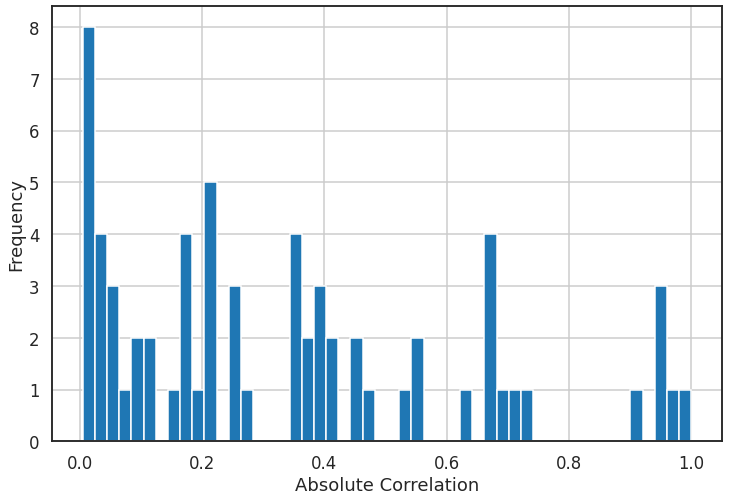

In [6]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [7]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.5')

,feature1,feature2,correlation,abs_correlation
38,na,nb,1.000000,1.000000
0,ln_eta_star_new,ln_eta_star,0.978244,0.978244
11,ln_eta_star,resd_entropy,0.944944,0.944944
49,nb,epsilon_k_ab,0.941050,0.941050
43,na,epsilon_k_ab,0.941050,0.941050
1,ln_eta_star_new,resd_entropy,0.910749,0.910749
32,molarweight,m,0.740765,0.740765
63,kappa_ab,epsilon_k_ab,0.710229,0.710229
48,nb,kappa_ab,0.667487,0.667487
42,na,kappa_ab,0.667487,0.667487


Checking the correlations provides some interesting insights. na, nb and ebsilon_k_ab are highly correlated. This is expectable when we look at the definitions: ebsilon_k_ab the association energy between association sites a and b, whereas na and nb are the number of association sites a and b.
Therefore we decided to exclude na and nb from the dataset as they are well-represented by ebsilon_k_ab. You can see this when you check the correlations between na, nb and ebsilon_k_ab and kappa_ab, sigma and so on. They show the same behavior every time.


The correlations between ln_eta_star_new and resd_entropy and molecularweight and m are also expected. In those cases the correlation patterns are not that clear. Therfore nothing was excluded here and the relationship between the two pairs is substance-specific and maybe useful for classification. Molecule lengths m and weights are probably not useful for our classification task, since each class contains short, long, heavy and light substances

This leads to the following feature columns:

In [8]:
#data[ "eta_entropy" ]     = data['ln_eta_star']*data['resd_entropy']
#data[ "eta_entropy_new" ] = data['ln_eta_star_new']*data['resd_entropy']

feature_cols = [ 'ln_eta_star_new', 'resd_entropy',
        'molarweight', 'm', 'sigma', 'epsilon_k', 'kappa_ab',
        'epsilon_k_ab', 'mu']

feature_cols = [  'm', 'sigma', 'epsilon_k', 'kappa_ab',
        'epsilon_k_ab', 'mu']

data = data[ feature_cols+["family"] ]
data = data.drop_duplicates()
data = data[ data["family"] != 'Other compounds' ]

Now we need to check the different families. 

We decided to exclude all families with below 400 samples from the dataset. 

In addition, families with a lot of samples are challenging. For example for Alkanes there are around 14000 samples and around 4500 for Alcohols. A classifier that properly distinguishes Alkanes from Alcohols would appear as very good even when it fails for all other families (this classifier would als be trivial because epsilon_k_ab is zero for Alkanes but not for Alcohols). So we deleted random samples when more than 1000 samples are available for one family. This is justifiable since it is an initial study.

Furthermore we deleted the family 'Other compounds' as it might be a quite random one. 

In [9]:
xxxx = False
if xxxx:
    for x in np.unique(data["family"]):
        no = len( np.array( data[ data["family"] == x] )    )
        print(x, no)
        if no < 400:
            data = data[ data["family"] != x ]
            print("deleted: ",x)
        if no > 1000:
            drop = np.random.choice( no-1,no-1000, replace=False )
            ii = data[ data["family"] == x].index[drop]
            print(len(ii), data.size) 
            data = data.drop(ii,axis="index")
            print("thinned",x)
            print("remaining:", len( np.array( data[ data["family"] == x] )) )

        print("")
    data = data[ data["family"] != 'Other compounds' ]

    # we save the final dataset used in the following study :)
    
else:
    prev = ['Acids', 'Alcohols', 'Alkanes', 'Alkenes', 'Aromatic hydrocarbons',
        'Chlorides', 'Cyclic compounds', 'Elements', 'Esters', 'Fluorides',
        'Halogenated compounds', 'Inorganic compounds', 'Nitriles']

    for x in np.unique(data["family"]):
        no = len( np.array( data[ data["family"] == x] )    )
        print(x, no)
        if x in prev:
            None
        else:
            data = data[ data["family"] != x ]
            print("deleted: ",x)
            
data.to_csv( 'vis_dataset_class_cleaned.csv',sep="\t" )
data = pd.read_csv('vis_dataset_class_cleaned.csv',sep="\t")

uniq_fam = np.unique( data["family"] )
no_classes = len( uniq_fam )
uniq_fam, no_classes            

Acids 4
Alcohols 6
Aldehydes 2
deleted:  Aldehydes
Alkanes 29
Alkenes 5
Amines 1
deleted:  Amines
Aromatic hydrocarbons 11
Chlorides 7
Cyclic compounds 7
Elements 7
Esters 8
Ethers 3
deleted:  Ethers
Fluorides 17
Halogenated compounds 17
Inorganic compounds 14
Ketones 1
deleted:  Ketones
Nitriles 3
Polyfunctional compounds 2
deleted:  Polyfunctional compounds
Silanes/siloxanes 1
deleted:  Silanes/siloxanes
Sulfides/thiophenes 3
deleted:  Sulfides/thiophenes


(array(['Acids', 'Alcohols', 'Alkanes', 'Alkenes', 'Aromatic hydrocarbons',
        'Chlorides', 'Cyclic compounds', 'Elements', 'Esters', 'Fluorides',
        'Halogenated compounds', 'Inorganic compounds', 'Nitriles'],
       dtype=object),
 13)

We end up with 13 different classes.


The correlation patterns shows clear but non-trivial patterns:

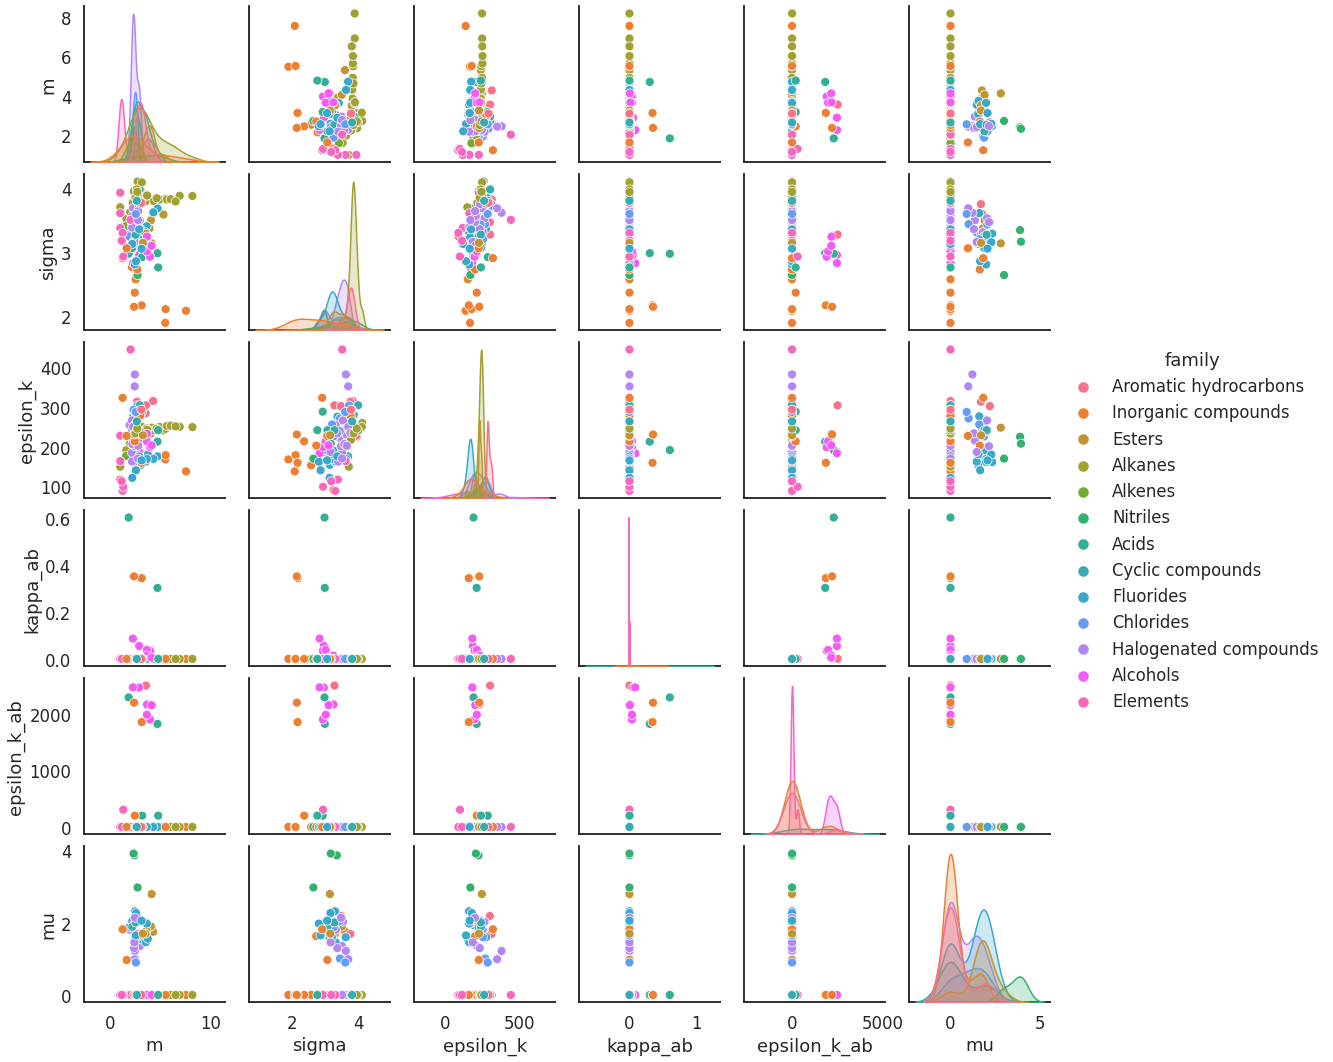

In [10]:
sns.pairplot(data[ feature_cols+["family"] ] , hue='family')

# 2. Goals

In this study we want to apply several classification methods to the introduced dataset.

We want to investigate two questions:

- is it possible to classify the species based on the given features?
- which of the features are most-suited for classification?

This leads to the following steps:

- split data into training and test set
- use logistic regression to get a feeling for the dataset and feature importance
- apply different methods (listed below), tune hyperparameters if necessary
- compare different methods


### Methods to be compared:

- logistic regression
- KNN
- Support Vector Machines (linear decision bound and kernel)
- Decision Trees
- Random Forest


## Preparing the data

Here data will be scaled and transormed.

All feature cols are float values. Therefore we need to normalize them with the standard scaler. Families to be predicted are label encoded,

The dataset is split into training and test data with stratified shuffling.


In [11]:
le = LabelEncoder()
data["family"] = le.fit_transform(data.family)
data["family"][:5]

0     4
1    11
2     4
3    11
4     8
Name: family, dtype: int64

In [12]:
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split( data[feature_cols], data["family"]))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'family']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'family']

#scaler = MinMaxScaler()
scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


# 3. Logistic regression

Since we use a lot of different features, we will first analyse the data set and the importance of the features with logistic regression to get a feeling for the data set and the features.


In [13]:
rs=42
# Our classification problem is multinomial
multi_class = 'multinomial'
# Max iteration = 1000
max_iter = 10000


In [14]:
# Standard logistic regression
solver = 'lbfgs'
lr = LogisticRegression(random_state=rs, multi_class=multi_class,max_iter=max_iter)
                        #solver=solver)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial', random_state=42)

In [15]:
# L1 regularized logistic regression
solver = 'saga'
lr_l1 = LogisticRegression(random_state=rs, multi_class=multi_class, penalty='l1',
                      solver=solver, max_iter=max_iter)
lr_l1.fit(X_train, y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial', penalty='l1',
                   random_state=42, solver='saga')

In [16]:
# L2 regularized logistic regression
solver="lbfgs" 
lr_l2 = LogisticRegression(random_state=rs, multi_class=multi_class,solver=solver,  penalty='l2',
                        max_iter=max_iter)
lr_l2.fit(X_train, y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial', random_state=42)

### now we can analyze the results:

In [17]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=np.arange(no_classes)),
              label_binarize(y_pred[lab], classes=np.arange(no_classes)), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)
metrics

/home/derwer/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/derwer/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/derwer/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,lr,l1,l2
precision,0.442509,0.444444,0.442509
recall,0.487805,0.487805,0.487805
fscore,0.450076,0.450259,0.450076
accuracy,0.487805,0.487805,0.487805
auc,0.704011,0.704011,0.704011


L1 performs better for all metrics on the test data than lr and l2. Therefore we will use l1 in the following. Nevertheless all approaches perform suprisingly well in all metrics. But there is still a little room for improvement.

The better performance of l1 is somehow expected, since we have chosen a lot of features, some of which are expectedly not suitable for classification as discussed before.

Now it is important to check the parameters in detail:

In [18]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = [ 'l1', 'l2','lr']
coeff_models = [ lr_l1, lr_l2,lr]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], np.arange(no_classes)], 
                                 codes=[ np.zeros(no_classes), np.arange(no_classes)])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients

l1                                                              \
         0         1         2         3         4         5         6    
0  1.361319  0.000000  1.406944 -0.842215  0.581968  0.000000  0.000000   
1 -0.371516  0.000000  4.834331  0.000000  0.000000  0.000000  0.463053   
2  0.000000 -0.151392 -1.186194  0.000000  1.700702  0.604014  0.629634   
3  1.141225 -0.050410  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  1.851817  0.000000  0.000000  0.615242  0.000000  0.000000   
5  0.000000  0.000000  0.000000 -0.322677 -0.601875  0.490927  0.000000   

                                 ...        lr                                \
         7         8         9   ...        3         4         5         6    
0 -3.658847  2.012186  1.328397  ... -0.881031  0.460034 -0.484636 -0.356970   
1  0.000000  0.000000  0.000000  ... -0.075624  0.324763 -0.067865  0.581386   
2 -0.629622  0.000000 -1.864244  ... -0.193203  1.572739  0.744691  0.759606   
3  0.000000  0.000000  0.000000  ... -0.072662 -0.194002 -0.045067 -0.028832   
4  0.000000  0.000000  0.000000  ... -0.196795  0.509454 -0.148425 -0.117221   
5  0.000000  1.289080  0.947461  ... -0.670581 -0.617743  0.400006 -0.129714   

                                                               
         7         8         9         10        11        12  
0 -1.936921  1.511814  0.962725 -0.612087 -0.698919 -0.222430  
1  0.321360 -0.253569 -0.105360 -0.124891 -1.960078 -0.050046  
2 -1.036662  0.287820 -1.577318  0.157013  0.180087 -0.110777  
3 -0.103231 -0.090548 -0.129877 -0.109318  0.269508 -0.003078  
4  0.105767 -0.261510 -0.435715 -0.361624 -0.479978 -0.007633  
5 -0.450368  0.931263  0.641516 -0.031528 -0.620705  1.838309  

[6 rows x 39 columns]

L1 cancels out some coefficients. This is good because we offer a lot of features, some of which are probably not usable for classification tasks.


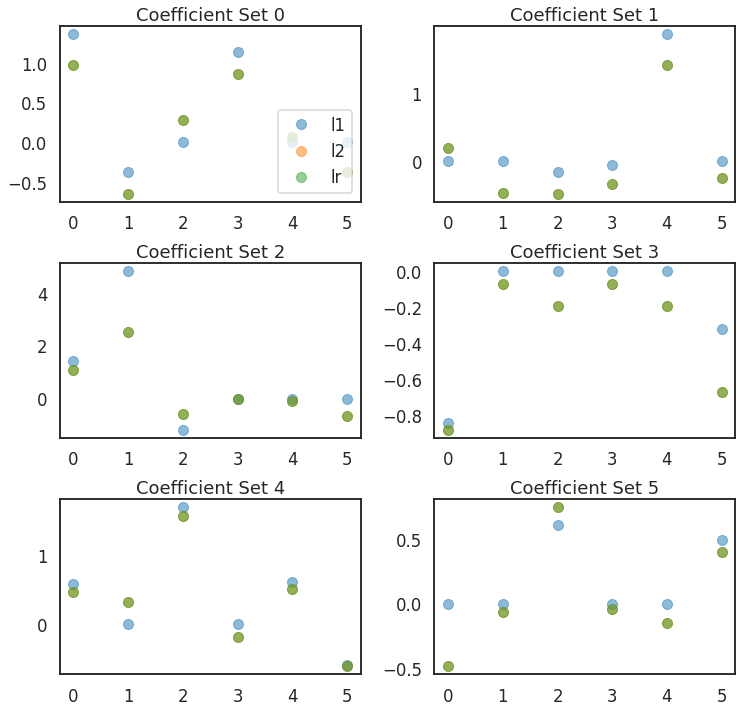

In [19]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    dummy = coefficients.xs(loc, level=1, axis=1)
    dummy.plot(marker='o', ls='', ms=10.0, ax=ax, legend=False, alpha=0.5)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

Linear regression and l2 parameters are basically identical.

In [20]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()


Now it is important to look in detail at which parameters are not needed due to the l1 panalty wheras
lr and l2 use all parameters and give them at leat some weight:

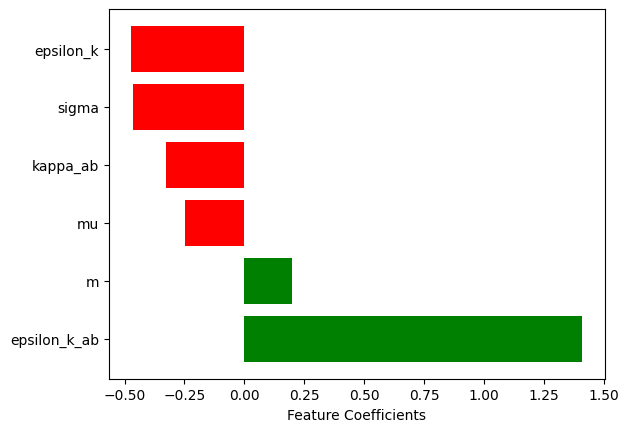

In [21]:
coef_dict = get_feature_coefs(lr_l2, 1, feature_cols)
visualize_coefs(coef_dict)

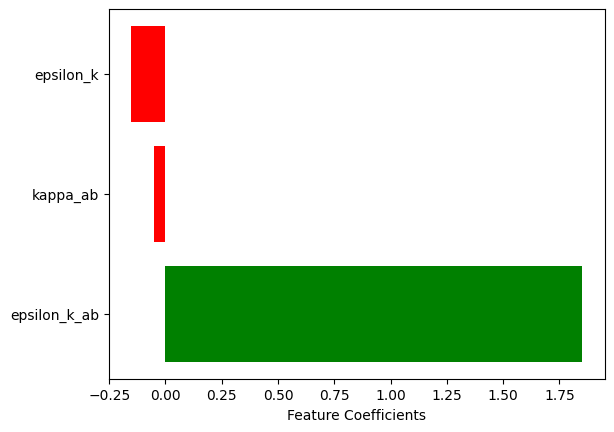

In [22]:
# Get the coefficents for Class 1, Less Often
coef_dict = get_feature_coefs(lr_l1, 1, feature_cols)
visualize_coefs(coef_dict)

l1 cancels out most of the parameters.

For some features this is somehow expected: 
- 'molarweight' and 'm' are clearly chain length related. Every family contains substances with very different chain lengths. Therfore such values shout not be useful for classification.
- mu is related to dipoles. Dipoles depend on the number of functional groups and therefore not on classes. You find different dipoles in every class.

For others it is not that straightforward:
- sigma does not vary very much across classes.

Not cancelled are:
- epsilon_k_ab is expected to be very helpful for classification.

The following features play a role depending on the seed:
- kappa_ab and epsilon_k rarely both appear as important features, but rather alternate. They seem to play the same role. This seems reasonable as they share a pearson correlation coefficient of 0.71. This is a lot when we consider that epsilon_k is never zero whereas mu is zero for a lot of families.
- ln_eta_star_new and residual entropy are expected to be somehow useful when they play together. But similar to kappa_ab, it is not clear why these are useful features. It is quite conceivable that these features are only useful because different areas of the entropy space were measured for different families in the existing dataset, i.e. their importance could be a bias of the dataset. It is to be expected that ln_eta_star_new plays a greater role than resd_entropy.


In the last part of this chapter we want to look at which families are misclassified:

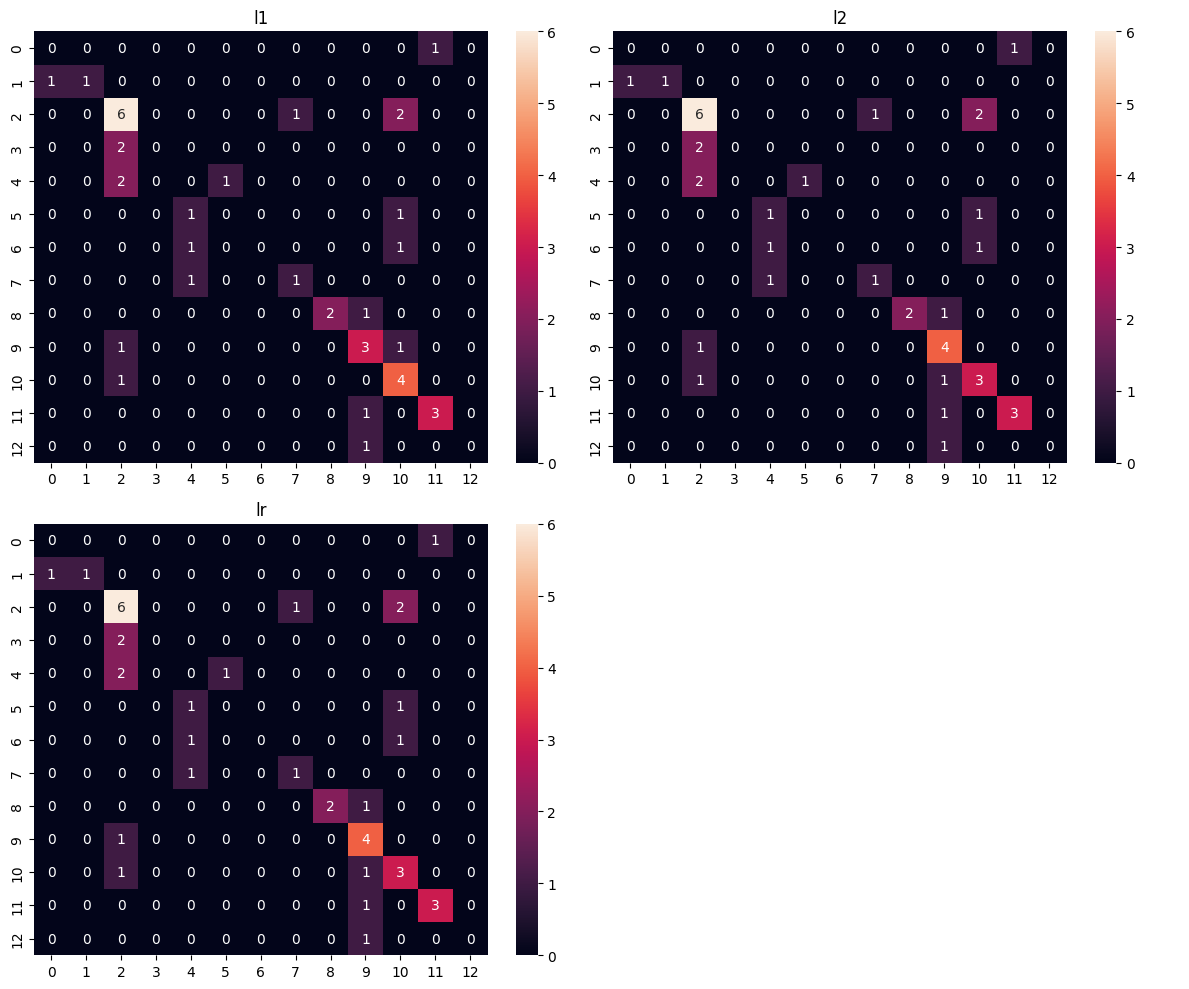

In [23]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [24]:
le.inverse_transform([2,3]), le.inverse_transform([10,11]), le.inverse_transform([4,6])

(array(['Alkanes', 'Alkenes'], dtype=object),
 array(['Halogenated compounds', 'Inorganic compounds'], dtype=object),
 array(['Aromatic hydrocarbons', 'Cyclic compounds'], dtype=object))

Alkanes and Alkenes are sometimes confused. This is to be expected as they are quite similar (compared to other families). L1 performes much better than lr and l2 in distinguishing Alkanes and Alkenes.

Furthermore Halogenated compounds and Inorganic compounds are confused which seems reasonable as both groups are quite general.

Aromatic hydrocarbons and Cyclic compounds are also quite similar as both contain ring structures. Therefore miscategorisations are nut suprising. Nevertheless l1 distinguishes between these families very well.


### Intermediate conclusion:

Linear regression classifiers work very well. An l1 penalty in particular delivers very convincing results and sorts out features in an extremely meaningful way. This is a very good basis for examining different classification methods, as there is still room for improvement, but the starting point is very good.

# 4. Comparing different classification methods

## 4.1 K nearest neighbors

In [25]:
# k nearest neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)

## 4.2 Support vectors

In [26]:
gammas = [1, 3, 5, 6]
svcs= []
svc_names= []
for gamma in gammas:
    SVC_Gaussian = SVC(kernel='rbf', gamma=gamma, probability=True)
    SVC_Gaussian.fit(X_train, y_train)
    svcs.append( SVC_Gaussian )
    svc_names.append( "svc"+str(gamma) )

## 4.3 Decision trees

In [27]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

rfs= []
rf_names= []

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [30,100, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)
    
    rfs.append(RF)
    rf_names.append( "rf"+str(n_trees) )

## 4.4 Comparing the approaches

In [29]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = [ 'l1', 'knn']+svc_names+["dt"]+rf_names
coeff_models = [ lr_l1, knn]+svcs+[dt]+rfs

for lab,mod in zip(coeff_labels, coeff_models):
    #print(lab)
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=np.arange(no_classes)),
              label_binarize(y_pred[lab], classes=np.arange(no_classes)), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)
metrics

/home/derwer/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/derwer/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/derwer/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/derwer/.local/lib/python3.10/si

,l1,knn,svc1,svc3,svc5,svc6,dt,rf30,rf100,rf400
precision,0.444444,0.545122,0.434088,0.405163,0.354878,0.367751,0.434727,0.562331,0.562331,0.562331
recall,0.487805,0.585366,0.512195,0.512195,0.439024,0.414634,0.463415,0.560976,0.560976,0.560976
fscore,0.450259,0.549957,0.465145,0.441421,0.378935,0.367230,0.433697,0.545616,0.545616,0.545616
accuracy,0.487805,0.585366,0.512195,0.512195,0.439024,0.414634,0.463415,0.560976,0.560976,0.560976
auc,0.704011,0.768673,0.723183,0.722509,0.677897,0.663633,0.701496,0.755131,0.755131,0.755131


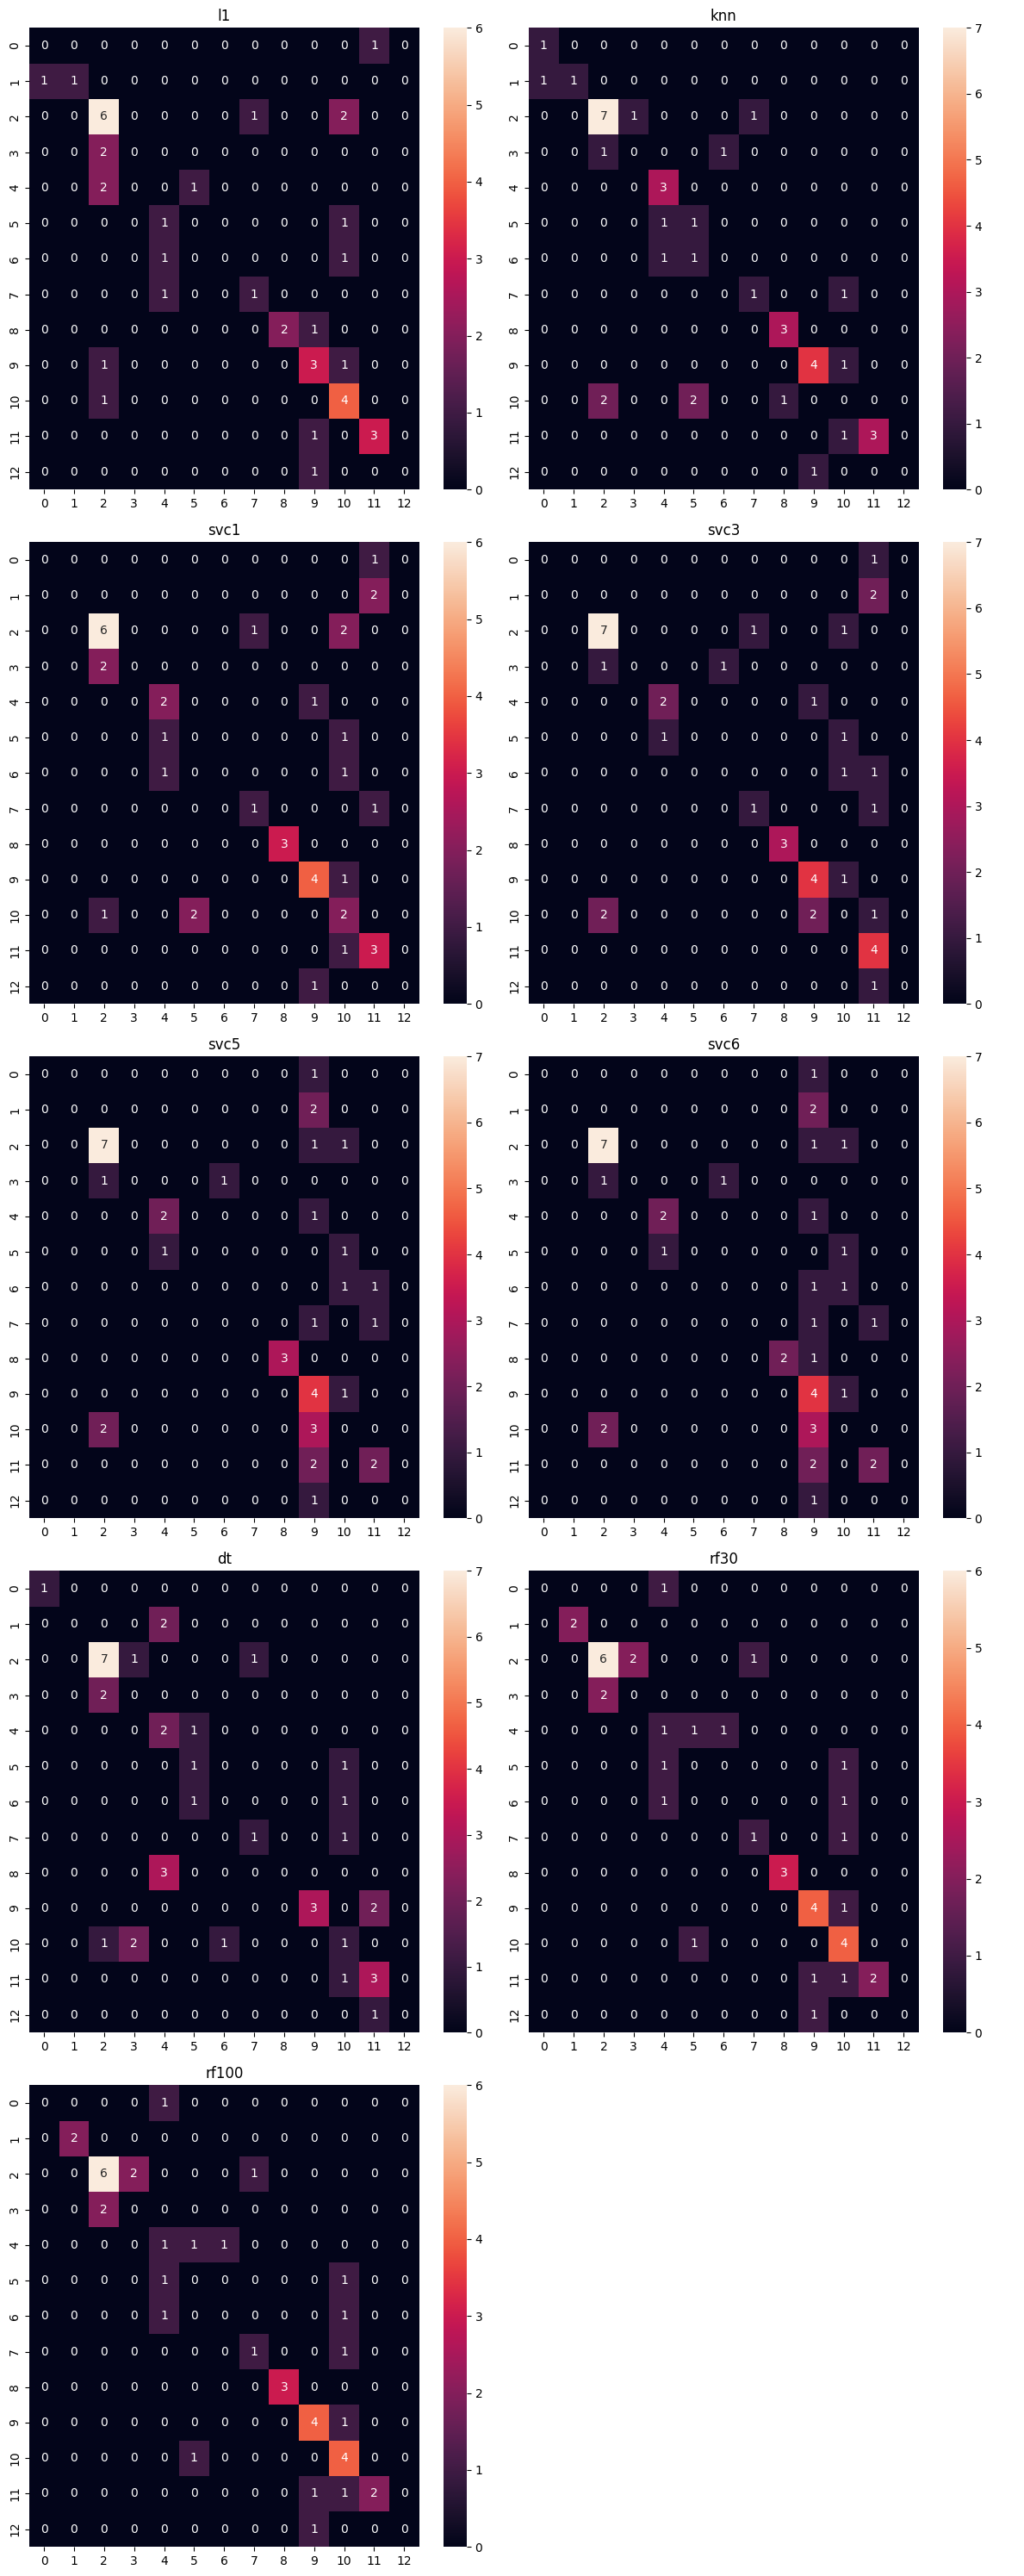

In [30]:
nrows= int( round( len(coeff_labels)/2 +0.49 ) )
fig, axList = plt.subplots(nrows= nrows, ncols=2)
axList = axList.flatten()
fig.set_size_inches( 12, nrows*6)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

Support vectors with RBF kernel and hyperparameter gamma=5 (svc5) works best with almost no missclassifications evern for hart to distinguis groups like Alkanes and Alkenes or Halogenated compounds and Inorganic compounds and thus represents an integral improvement over a linear classifier.

# 5. Insights and key findings


We investigated two questions:

### Is it possible to classify the species based on the given features?

Yes. Virtually all classification methods work very well. 

It is interesting that K-nearest neighbours provides good results, as features such as molecular weight and the m parameter can vary greatly within a family. This speaks in favour of good coverage of the ranges in the data set. However, when it really comes to the application, these features should be excluded if necessary.


Even linear regression with l1 penalty works very well, but has problems when differentiating between alkanes and alkenes, for example. 
This differentiation is possible with support vectors with RBF kernel, as these allow non-linear limits. With hyperparameter gamma=5 there are practically no more misclassifications, even with families that are difficult to distinguish.

### Which of the features are most-suited for classification?

Energy and association related parameters of the physical model are most-suited for classification as this is where different families differ the most.

However, reduced state variables like ln_eta_star_new and resd_entropy also appear to have a certain influence.
There are many samples per substance for these variables, while the physical parameters are substance-specific parameters. If many samples are available for a substance, the substance can be classified on the basis of an average of all available data.

It is interesting that we can predict the chemical family of a substance based on a few parameters of a physical model. Especially if you keep in mind that these parameters were (relatively) freely fitted without informing the odel about other members of the family. Among other things, this speaks in favour of the model.


# 6. Next Steps


Now that we know that the classification approach is promising, there is a variety next steps:

- As physical parameters are most suited for classification we should test whether a dataset without state points and only with parameters of the physical model is better suited to train a model. This data set would be much smaller and would only contain around 160 different substances.

- A lot of samples were initially thrown away in order to be able to represent all families equally in the training and test data. For an initial study, this is fine. In the following, a way should be found to be less wasteful with the available data.

- Since a large number of features were used, some of which were probably unsuitable, the aim should be to reduce the number of features without worsening the results. This should be possible based on the findings of this study.

- Classification tools can be used to support the parameter training for the physical model. If the family of a molecule is known, the parameters of the physical model should be correctly classified. If not this might indicate overfitting.
